# Social Web Analytics Final Project: TV Shows

### Group 4:
* Gavriel Owens Vincentio  BF21DSY004
* Joshua Benzon            BS20DSY027
* Prakhar Mishra           BS20DMU019
* Gargi Asthana            BS20DMU002
* Omkar Shitole            BS20DMU021

## Importing Libraries

In [1]:
# Multiprocessing
import multiprocessing
from multiprocessing import Manager
from multiprocessing.pool import ThreadPool as Pool

# Mute Warnings
import warnings
warnings.filterwarnings('ignore')

# Scraper
import snscrape.modules.twitter as sntwitter

# DataFrames
import pandas as pd
import numpy as np
import geopandas as gpd

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Misc
import re
from datetime import datetime
from tqdm.auto import tqdm
tqdm.pandas()

c:\Users\owens\virtual_environments\twitter-proj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Scraping Data

In [ ]:
# Defining Functions for Scraping
def scrape_All(n):
    tweets_list2 = []
    query = ' '.join([SEARCH_TERM, f'since:{getDateM(n)}', f'until:{getDateM(n+1)}', 'lang:en',])
    print(f"\nQuerying {getDateM(n)} to {getDateM(n+1)} on process thread no. {n}")
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        
        tweet_details = [
            tweet.date,
            tweet.id,
            tweet.user.username,
            tweet.rawContent,
            tweet.replyCount,
            tweet.retweetCount,
            tweet.likeCount,
            tweet.quoteCount,
            [i.username for i in tweet.mentionedUsers] if tweet.mentionedUsers else tweet.mentionedUsers,
            tweet.hashtags,
            tweet.coordinates,
            tweet.url
        ]
        tweets_list2.append(tweet_details)
    return pd.DataFrame(tweets_list2, columns = df_col, index=None)

def setDateM(s,e):
    return pd.date_range(s, e)

def getDateM(i):
    return dmonth[i].strftime('%Y-%m-%d')

In [ ]:
# Checking for CPU Threads for Multiprocessing
print("Number of CPU Threads Available: ", multiprocessing.cpu_count())
if multiprocessing.cpu_count() > 2:
    cpu_no = multiprocessing.cpu_count()-2  
else:
    cpu_no = multiprocessing.cpu_count()
    print("WARNING: Your system might get slow or unresponsive while scraping. \nPlease do not interact with the system while Data Scraping is in progress")  
print(f"Allocating {cpu_no} CPU Threads for Scraping")

In [ ]:
with Manager() as manager:
    df_col = ['datetime', 'tweet_id', 'username', 'text', 'reply_count', 'retweet_count', 'like_count', 'quote_count', 'mentions', 'hashtags', 'coordinates', 'link']
    tweets_df = pd.DataFrame(columns=df_col)
    
    SEARCH_TERM = "Last of Us"
    
    # Date Format below is mm/dd/yyyy
    start = '1/1/2023'
    end = '4/1/2023'
    dmonth = setDateM(start, end)

    sum_of_tweets = 0
    k = len(dmonth)
    pool = Pool(cpu_no)
    for result in pool.imap_unordered(scrape_All, range(0, len(dmonth)-1)):
        tweets_df = tweets_df.append(result, ignore_index=True)
        sum_of_tweets = sum_of_tweets + result.shape[0]
        k = k-1
        print(f"\nNo. of tweets extracted till now = {sum_of_tweets}. No. of process threads remaining = {k}")
    pool.close()

In [ ]:
tweets_df = tweets_df.sort_values(by='datetime', ascending=True)
tweets_df.to_csv(f"{SEARCH_TERM}.csv", index = False)

## Reading Files

In [2]:
# Reading scraped data
rop = pd.read_csv('rop.csv')

hotd = pd.read_csv('hotd.csv')

## Pipeline

In [3]:
sia = SentimentIntensityAnalyzer()

shows = [rop, hotd]

show_release = [pd.to_datetime("2022-09-01"), pd.to_datetime("2022-08-21")]
for n, show in enumerate(tqdm(shows)):
    show.drop_duplicates('text', inplace=True, keep='first')
    show.reset_index(inplace=True, drop=True)

    show["text"] = show['text'].apply(lambda x: re.sub(r"http\S+", "", x))
    show["text"] = show['text'].apply(lambda x: re.sub(r"www.\S+", "", x))
    show['text'] = show['text'].apply(lambda x: x.lower())
    show["text"] = show['text'].apply(lambda x: re.sub(r'[@#]', "", x))

    show['day'], show['week'], show['month'], show['date'] = pd.DatetimeIndex(show['datetime']).dayofyear, pd.DatetimeIndex(show['datetime']).weekofyear, pd.DatetimeIndex(show['datetime']).month, pd.DatetimeIndex(show['datetime']).date

    show['days_since_release'] = (pd.to_datetime(show['date']) - show_release[n]).dt.days
    show['weeks_since_release'] = pd.to_numeric(np.floor(show['days_since_release']/7), downcast = 'signed')

    polarity = [sia.polarity_scores(show['text'][i]) for i in range(len(show))]

    neg = [polarity[i]['neg'] for i in range(len(polarity))]
    neu = [polarity[i]['neu'] for i in range(len(polarity))]
    pos = [polarity[i]['pos'] for i in range(len(polarity))]
    compound = [polarity[i]['compound'] for i in range(len(polarity))]
    sentiment = ['pos' if (polarity[i]['compound'] >= 0.05) else 
                'neg' if (polarity[i]['compound'] <= -0.05) else
                'neu' for i in range(len(polarity))]

    show['neg'], show['neu'], show['pos'], show['comp'], show['sentiment'] = neg, neu, pos, compound, sentiment

    show['adjcomp'] = show["comp"] * (show["like_count"] + show["retweet_count"] + 1)/((show["quote_count"] + show["reply_count"]) * 0.1 + 1)


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\owens\AppData\Local\Temp\ipykernel_18764\418661541.py:16: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  show['day'], show['week'], show['month'], show['date'] = pd.DatetimeIndex(show['datetime']).dayofyear, pd.DatetimeIndex(show['datetime']).weekofyear, pd.DatetimeIndex(show['datetime']).month, pd.DatetimeIndex(show['datetime']).date
 50%|█████     | 1/2 [00:31<00:31, 31.31s/it]C:\Users\owens\AppData\Local\Temp\ipykernel_18764\418661541.py:16: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  show['day'], show['wee

### Displaying Files

In [4]:
rop.head(5)

,datetime,tweet_id,username,text,reply_count,retweet_count,like_count,quote_count,mentions,hashtags,...,month,date,days_since_release,weeks_since_release,neg,neu,pos,comp,sentiment,adjcomp
0,2022-08-31 23:59:56+00:00,1565127277850947585,philbertdy,i got sent the first two episodes of the rings...,1,2,46,5,NaN,NaN,...,8,2022-08-31,-1,-1,0.028,0.730,0.242,0.9186,pos,28.132125
1,2022-08-31 23:59:47+00:00,1565127239141916675,SweetTalkBlog,the lord of the rings: the rings of power revi...,0,0,0,0,NaN,NaN,...,8,2022-08-31,-1,-1,0.000,0.808,0.192,0.8109,pos,0.810900
2,2022-08-31 23:59:42+00:00,1565127218572959745,cinepacino,the rings of power tomorrow finally,0,0,1,0,NaN,NaN,...,8,2022-08-31,-1,-1,0.000,1.000,0.000,0.0000,neu,0.000000
3,2022-08-31 23:59:32+00:00,1565127178710310912,johnettesnuggs,at a special fan screening of the first 2 ring...,2,0,5,0,NaN,NaN,...,8,2022-08-31,-1,-1,0.000,0.709,0.291,0.8729,pos,4.364500
4,2022-08-31 23:59:25+00:00,1565127146871427074,aflawedmanofGod,ifffster its going to be bad.\n\namazon ruined...,0,0,0,0,['ifffster'],NaN,...,8,2022-08-31,-1,-1,0.342,0.599,0.060,-0.8402,neg,-0.840200


In [5]:
hotd.head(5)

,datetime,tweet_id,username,text,reply_count,retweet_count,like_count,quote_count,mentions,hashtags,...,month,date,days_since_release,weeks_since_release,neg,neu,pos,comp,sentiment,adjcomp
0,2022-08-31 23:59:59+00:00,1565127292040396801,nickhammy5,send alicent hightower to the wall (bonus: hou...,1,0,2,1,NaN,NaN,...,8,2022-08-31,10,1,0.000,0.759,0.241,0.5423,pos,1.35575
1,2022-08-31 23:59:47+00:00,1565127239141916675,SweetTalkBlog,the lord of the rings: the rings of power revi...,0,0,0,0,NaN,NaN,...,8,2022-08-31,10,1,0.000,0.808,0.192,0.8109,pos,0.81090
2,2022-08-31 23:59:19+00:00,1565127121558708229,GamingNews242,house of the dragon’s miguel sapochnik leaving...,0,0,0,0,NaN,NaN,...,8,2022-08-31,10,1,0.000,1.000,0.000,0.0000,neu,0.00000
3,2022-08-31 23:57:50+00:00,1565126749939179521,natalha_______,finalmente vendo house of the dragon 🙏🏻😭,0,0,0,0,NaN,NaN,...,8,2022-08-31,10,1,0.193,0.807,0.000,-0.4767,neg,-0.47670
4,2022-08-31 23:57:46+00:00,1565126731639521281,slasher_steve,the lord of the rings: the rings of power revi...,0,0,0,0,NaN,NaN,...,8,2022-08-31,10,1,0.000,0.847,0.153,0.5598,pos,0.55980


## Visualisations

### World Map

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\3240593381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rop_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[0]) for i in range(len(rop_df))]
C:\Users\owens\AppData\Local\Temp\ipykernel_18764\3240593381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rop_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[1]) for i in range(len(rop_df)

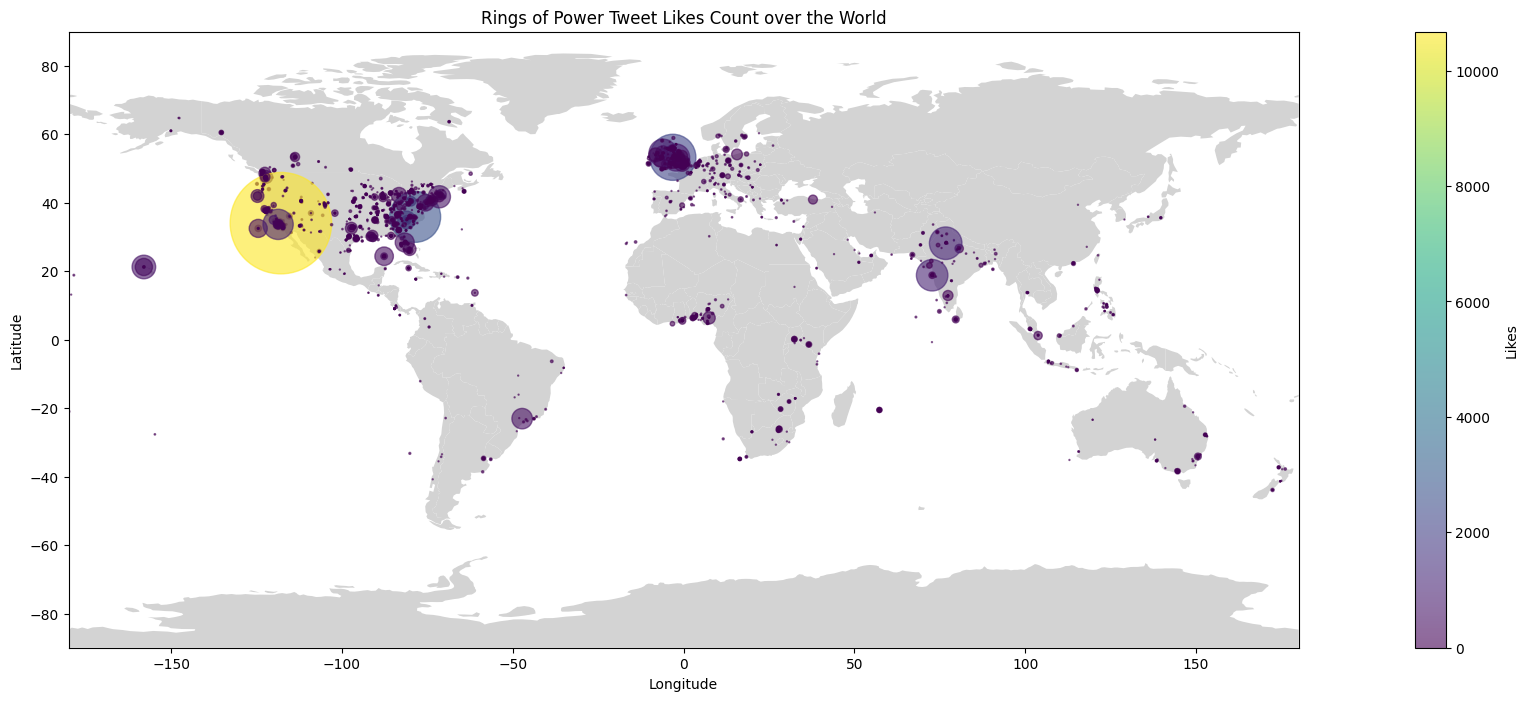

In [6]:
rop_df = rop[rop['coordinates'].notna()==True]
rop_df.reset_index(inplace=True)

rop_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[0]) for i in range(len(rop_df))]
rop_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[1]) for i in range(len(rop_df))]

fig, ax = plt.subplots(figsize=(30,8))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

plt.scatter(rop_df["longitude"], rop_df["latitude"], c=rop_df['like_count'], s=0.5*rop_df['like_count'], alpha=0.6)
plt.colorbar(label='Likes')

plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title("Rings of Power Tweet Likes Count over the World")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\2142576027.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rop_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[0]) for i in range(len(rop_df))]
C:\Users\owens\AppData\Local\Temp\ipykernel_18764\2142576027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rop_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[1]) for i in range(len(rop_df)

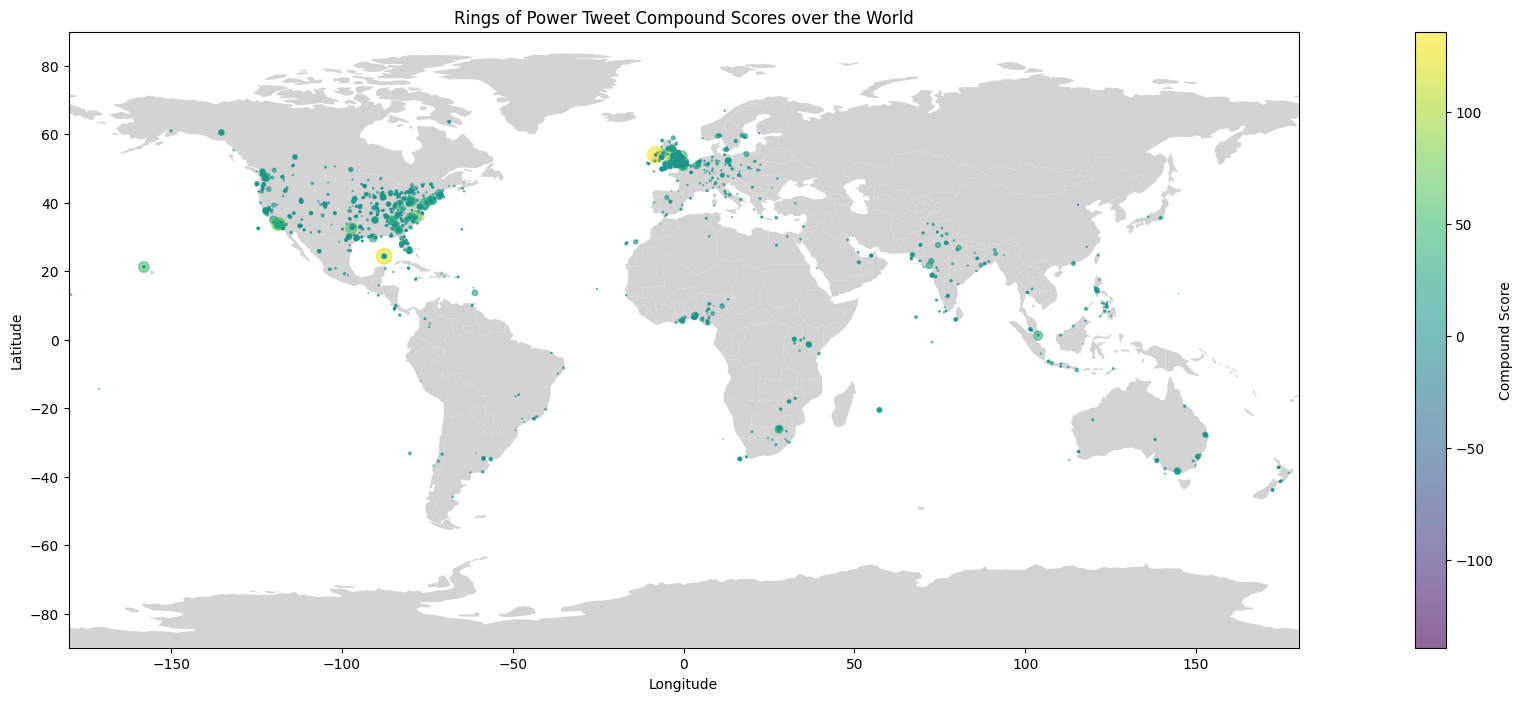

In [7]:
rop_df = rop[rop['coordinates'].notna()==True]
rop_df.reset_index(inplace=True)

rop_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[0]) for i in range(len(rop_df))]
rop_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', rop_df['coordinates'][i])[1]) for i in range(len(rop_df))]

fig, ax = plt.subplots(figsize=(30,8))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

plt.scatter(rop_df["longitude"], rop_df["latitude"], c=rop_df['adjcomp'], s=rop_df['adjcomp'], alpha=0.6)
plt.colorbar(label='Compound Score')

plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title("Rings of Power Tweet Compound Scores over the World")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\743147057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotd_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[0]) for i in range(len(hotd_df))]
C:\Users\owens\AppData\Local\Temp\ipykernel_18764\743147057.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotd_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[1]) for i in range(len(hotd

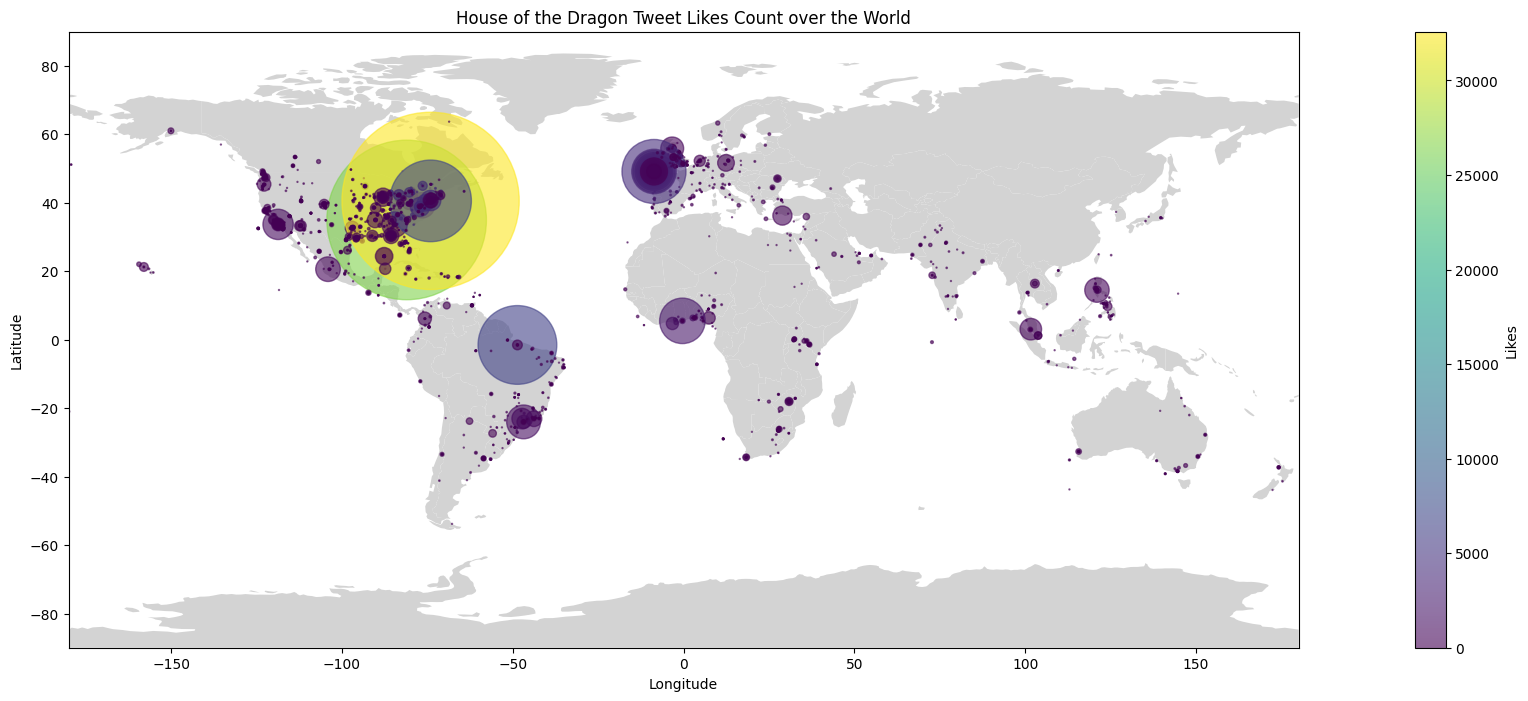

In [8]:
hotd_df = hotd[hotd['coordinates'].notna()==True]
hotd_df.reset_index(inplace=True)

hotd_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[0]) for i in range(len(hotd_df))]
hotd_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[1]) for i in range(len(hotd_df))]

fig, ax = plt.subplots(figsize=(30,8))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

plt.scatter(hotd_df["longitude"], hotd_df["latitude"], c=hotd_df['like_count'], s=0.5*hotd_df['like_count'], alpha=0.6)
plt.colorbar(label='Likes')

plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title("House of the Dragon Tweet Likes Count over the World")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\380094388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotd_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[0]) for i in range(len(hotd_df))]
C:\Users\owens\AppData\Local\Temp\ipykernel_18764\380094388.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotd_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[1]) for i in range(len(hotd

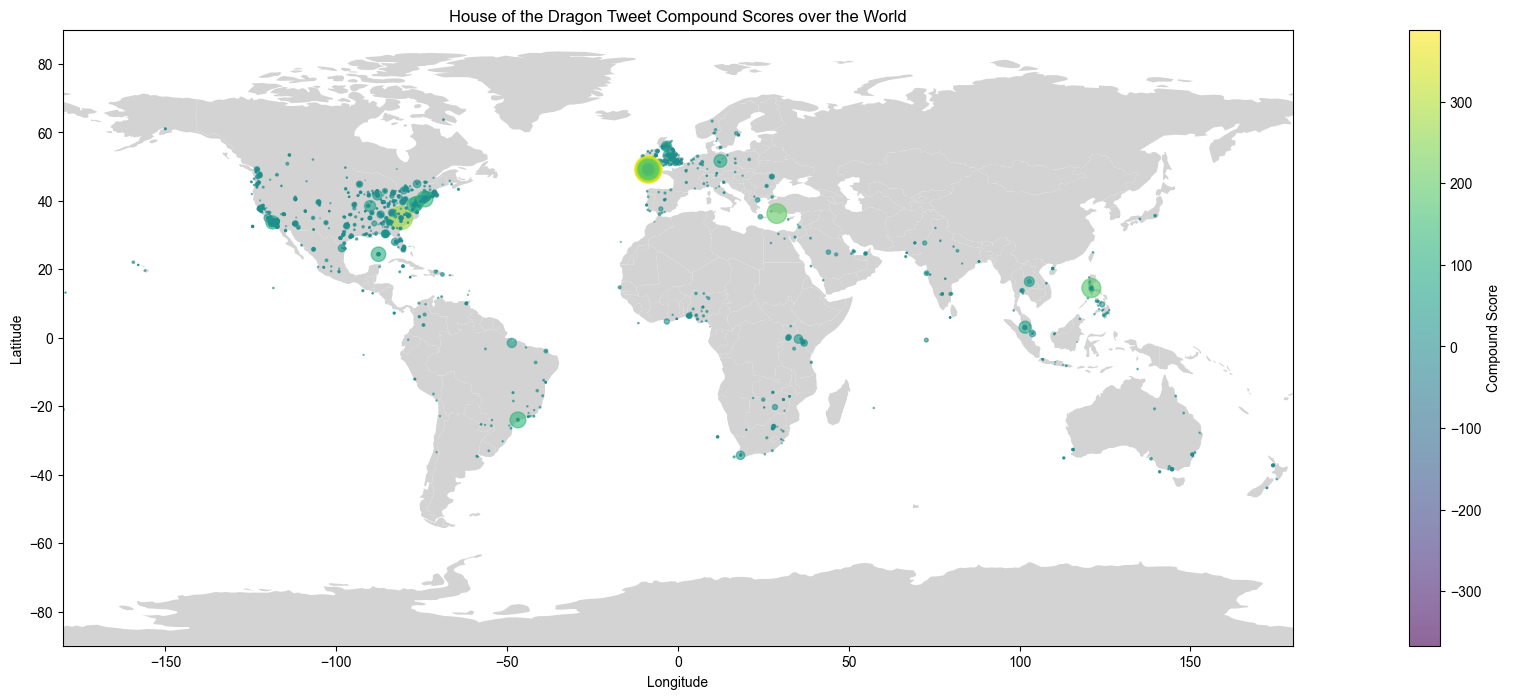

In [9]:
hotd_df = hotd[hotd['coordinates'].notna()==True]
hotd_df.reset_index(inplace=True)

hotd_df['longitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[0]) for i in range(len(hotd_df))]
hotd_df['latitude'] = [float(re.findall(r'[-+]?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?', hotd_df['coordinates'][i])[1]) for i in range(len(hotd_df))]

fig, ax = plt.subplots(figsize=(30,8))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

plt.scatter(hotd_df["longitude"], hotd_df["latitude"], c=hotd_df['adjcomp'], s=hotd_df['adjcomp'], alpha=0.6)
plt.colorbar(label='Compound Score')

plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.style.use('seaborn')
plt.title("House of the Dragon Tweet Compound Scores over the World")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Line Chart

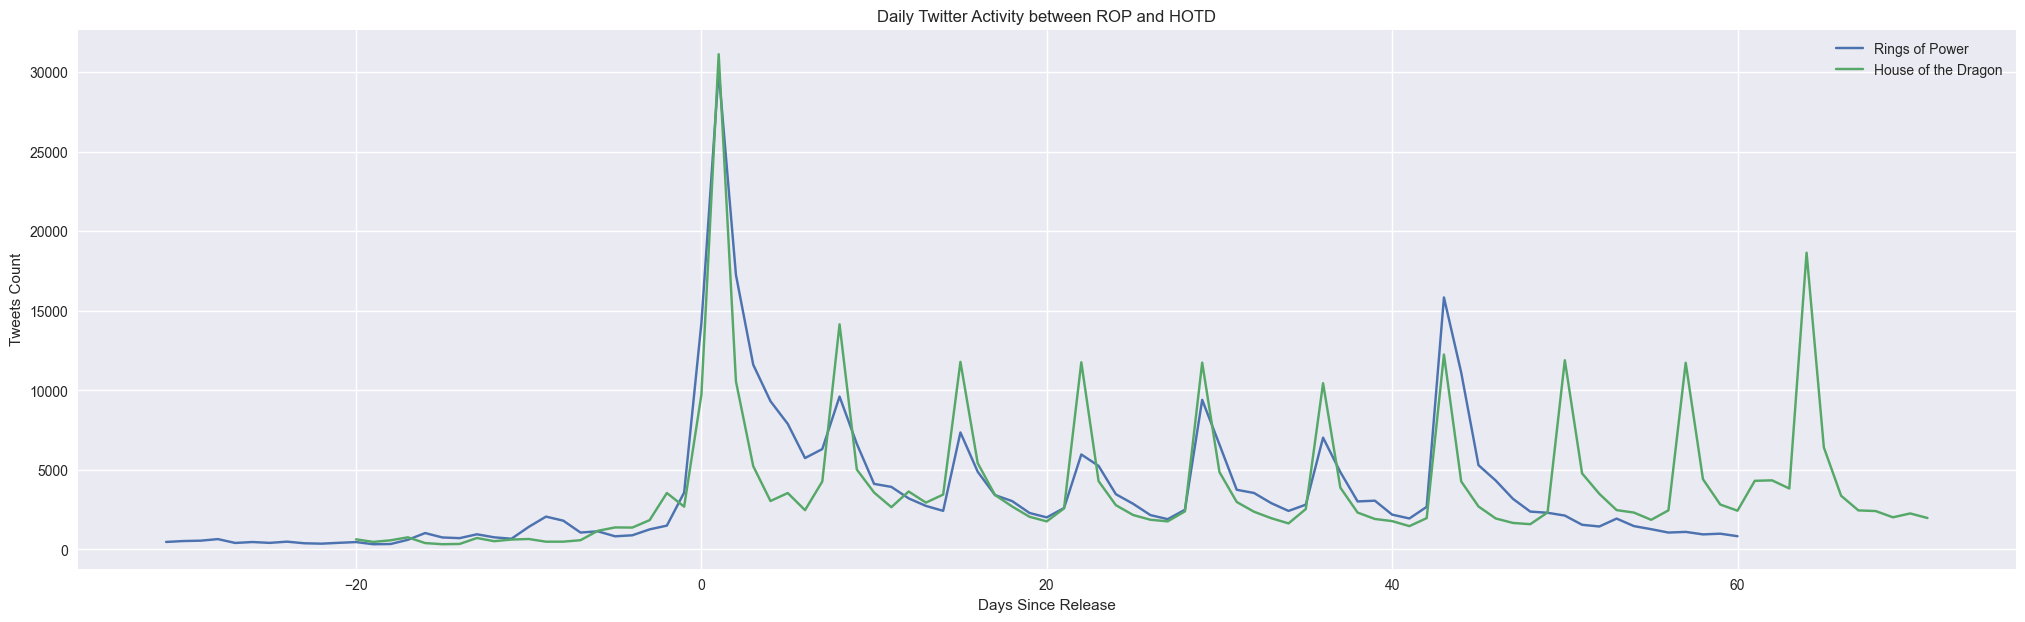

In [10]:
rop_df = rop.groupby(['days_since_release'])['text'].count()
hotd_df = hotd.groupby(['days_since_release'])['text'].count()

fig, ax = plt.subplots(figsize=(25, 7))
rop_df.plot(x = 'days_since_release')
hotd_df.plot(x = 'days_since_release')
plt.grid(zorder=0)
plt.legend(['Rings of Power', 'House of the Dragon'])
plt.xlabel('Days Since Release')
plt.ylabel('Tweets Count')
plt.title('Daily Twitter Activity between ROP and HOTD')
plt.xticks()
plt.show()

### Bar Charts

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\1992723008.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


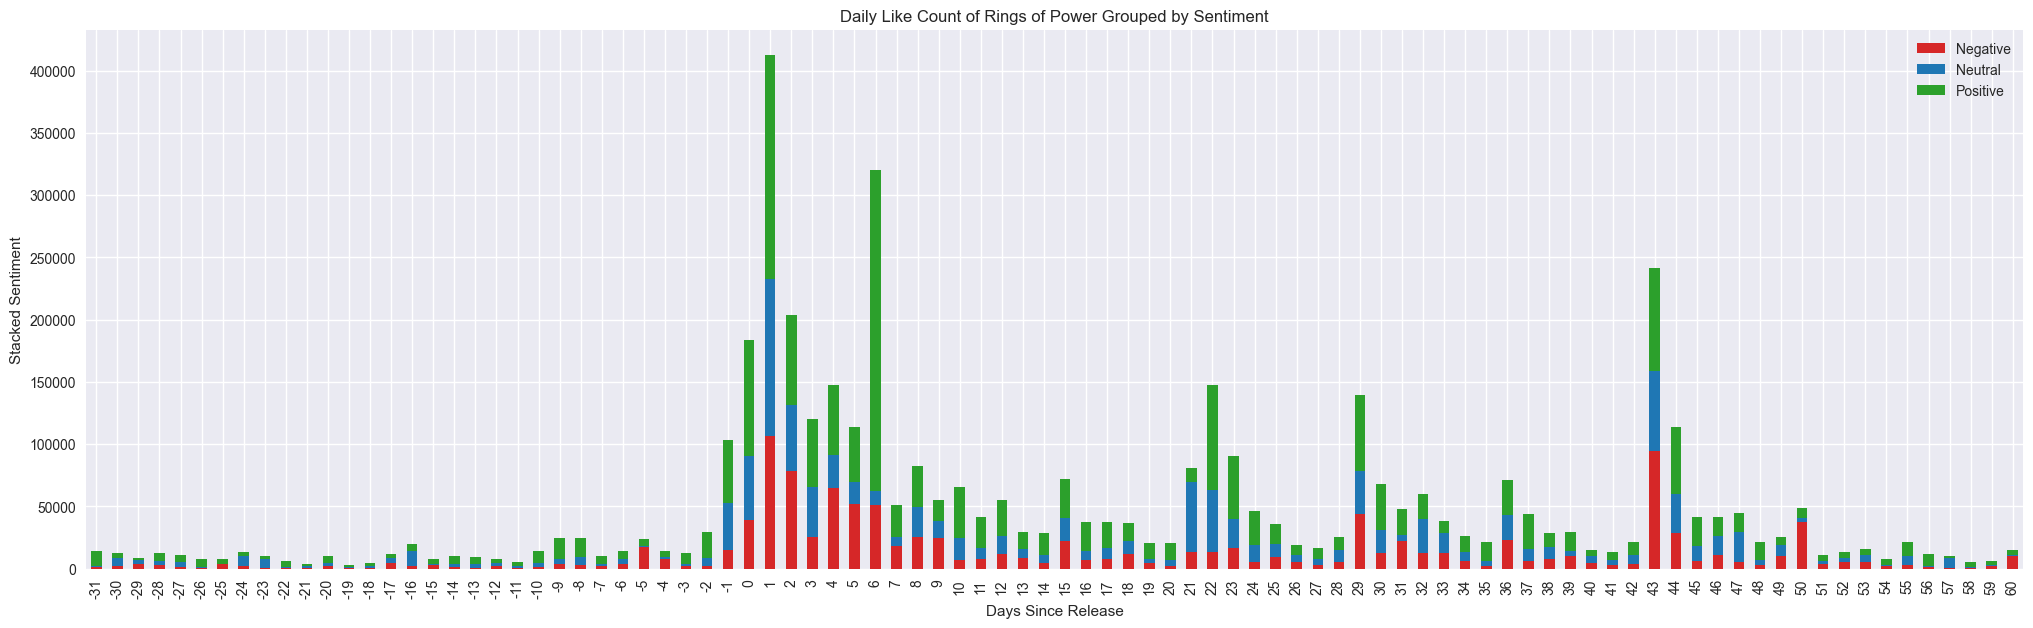

In [11]:
df_plot = rop.groupby(['days_since_release', 'sentiment'])['like_count'].sum().unstack(level=1)
df_plot.plot(kind='bar', stacked=True, figsize=(25,7), color = ['tab:red', 'tab:blue', 'tab:green'])
plt.style.use('seaborn-notebook')
plt.title('Daily Like Count of Rings of Power Grouped by Sentiment')
plt.legend(["Negative", "Neutral", "Positive"])
plt.xlabel('Days Since Release')
plt.ylabel('Stacked Sentiment')
plt.show()

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\630977131.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


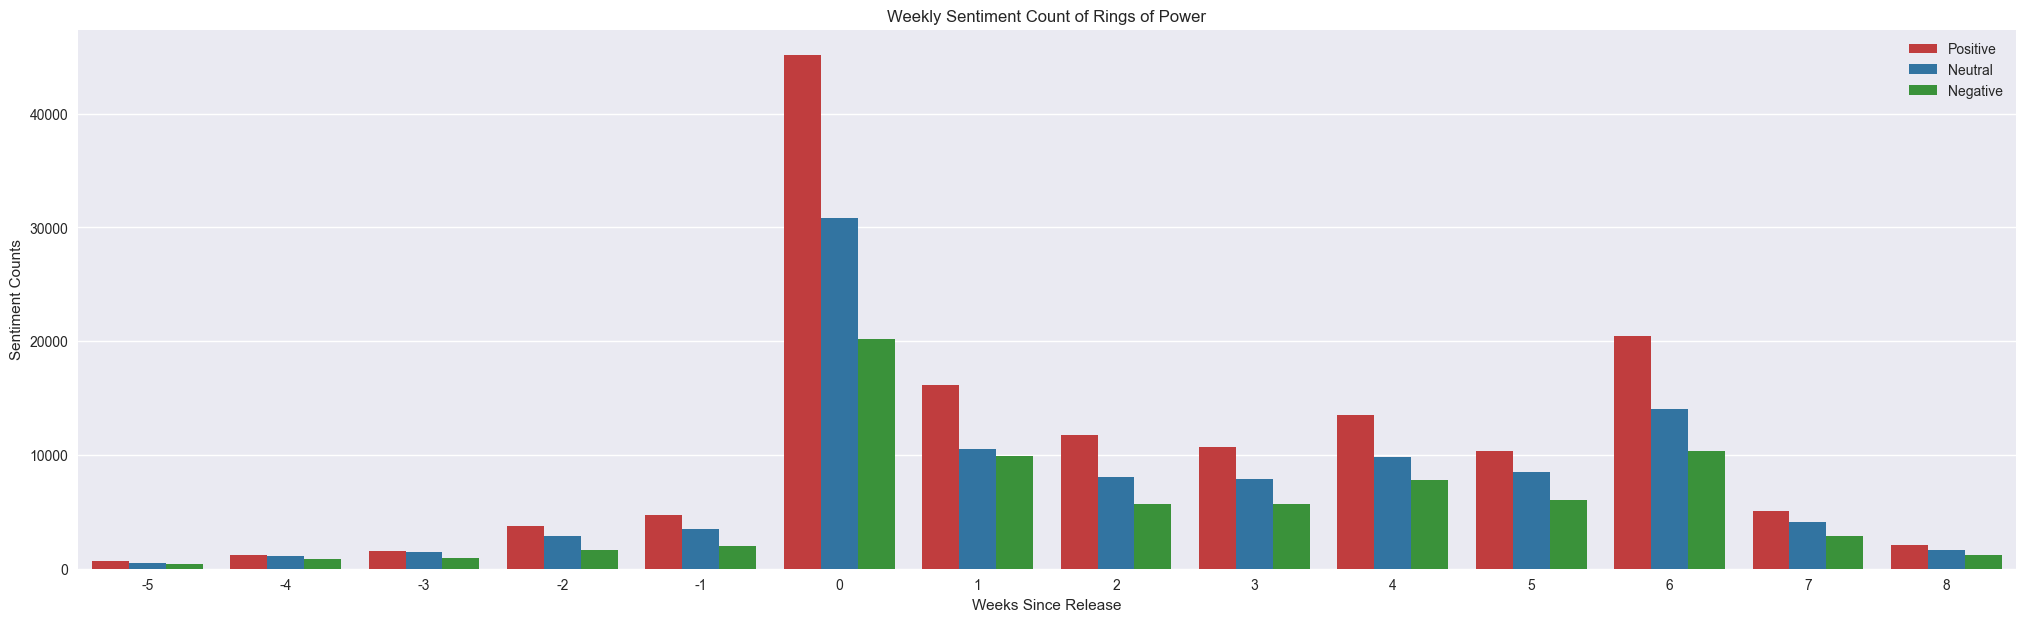

In [12]:
plt.figure(figsize=(25,7))
sns.countplot(x='weeks_since_release',hue='sentiment',data=rop, palette=['tab:red', 'tab:blue', 'tab:green'])
plt.style.use('seaborn')
plt.title('Weekly Sentiment Count of Rings of Power')
plt.legend(['Positive', 'Neutral', 'Negative'])
plt.xlabel('Weeks Since Release')
plt.ylabel('Sentiment Counts')
plt.show()

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\1725083077.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


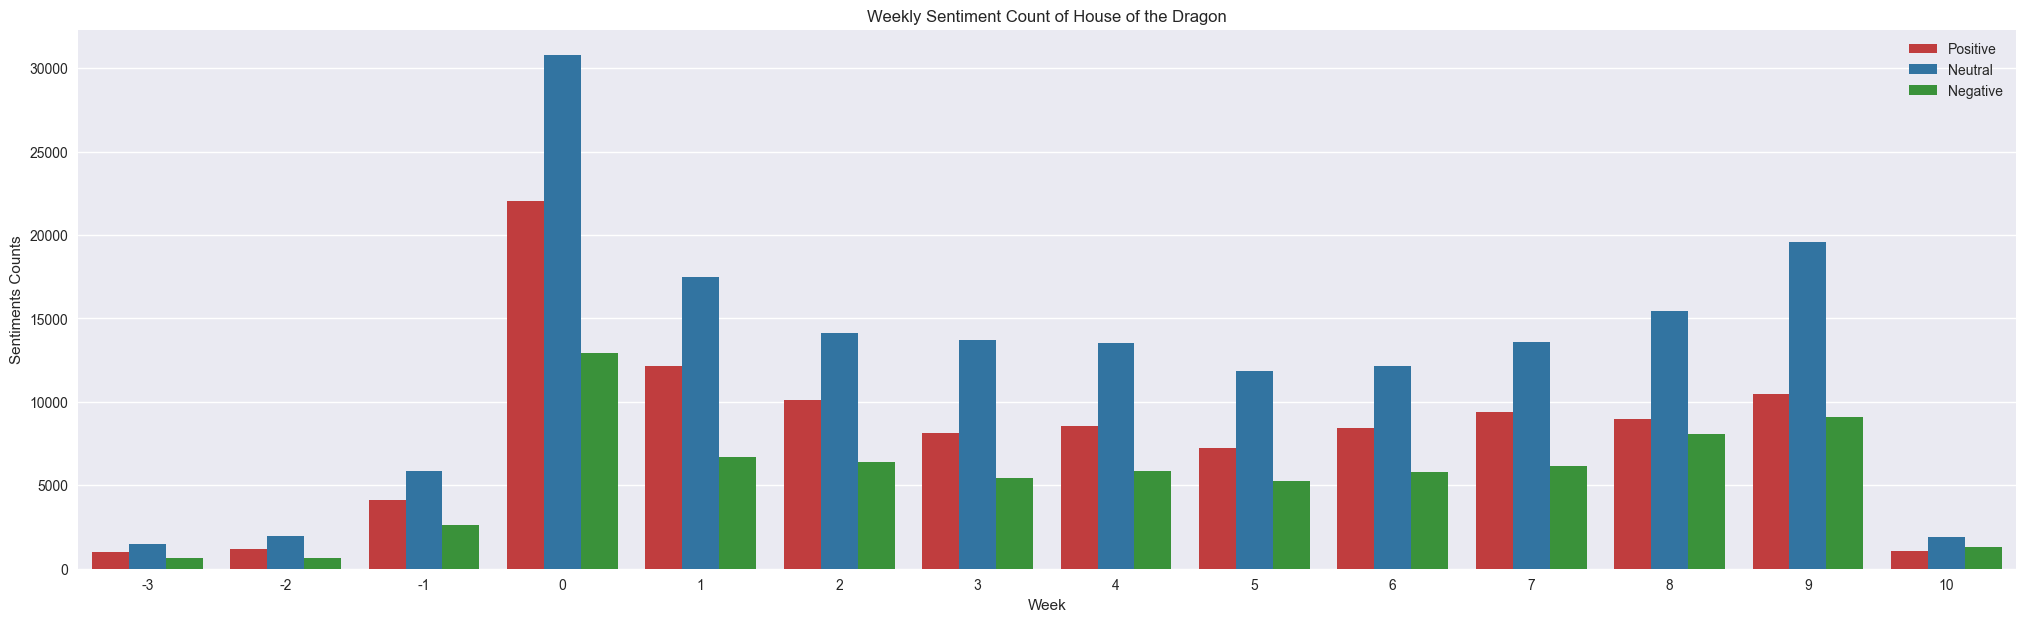

In [13]:
plt.figure(figsize=(25,7))
sns.countplot(x='weeks_since_release',hue='sentiment',data=hotd, palette=['tab:red', 'tab:blue', 'tab:green'])
plt.style.use('seaborn')
plt.title('Weekly Sentiment Count of House of the Dragon')
plt.legend(['Positive', 'Neutral', 'Negative'])
plt.xlabel('Week')
plt.ylabel('Sentiments Counts')
plt.show()

### Pie Charts

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\3103367068.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


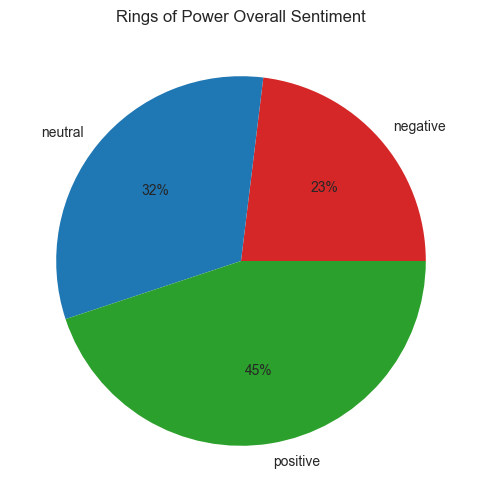

C:\Users\owens\AppData\Local\Temp\ipykernel_18764\3103367068.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


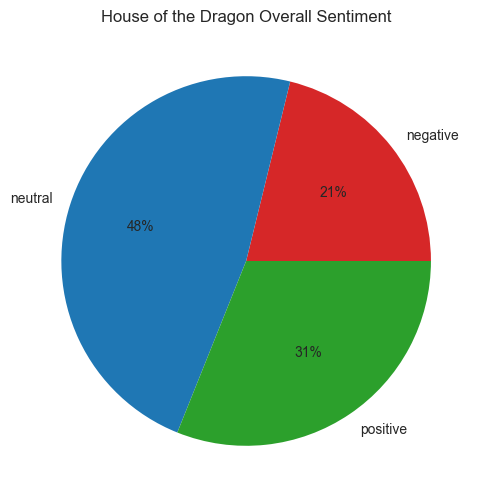

In [14]:
plt.figure(figsize=(6,6))
plt.style.use('seaborn')
plt.pie(rop.groupby(['sentiment'])['sentiment'].count(), 
        labels=['negative', 'neutral' ,'positive'], 
        colors=['tab:red', 'tab:blue', 'tab:green'], 
        autopct='%.0f%%')
plt.title('Rings of Power Overall Sentiment')
plt.show()

plt.figure(figsize=(6,6))
plt.style.use('seaborn')
plt.pie(hotd.groupby(['sentiment'])['sentiment'].count(), 
        labels=['negative', 'neutral' ,'positive'], 
        colors=['tab:red', 'tab:blue', 'tab:green'], 
        autopct='%.0f%%')
plt.title('House of the Dragon Overall Sentiment')
plt.show()

### Line Charts

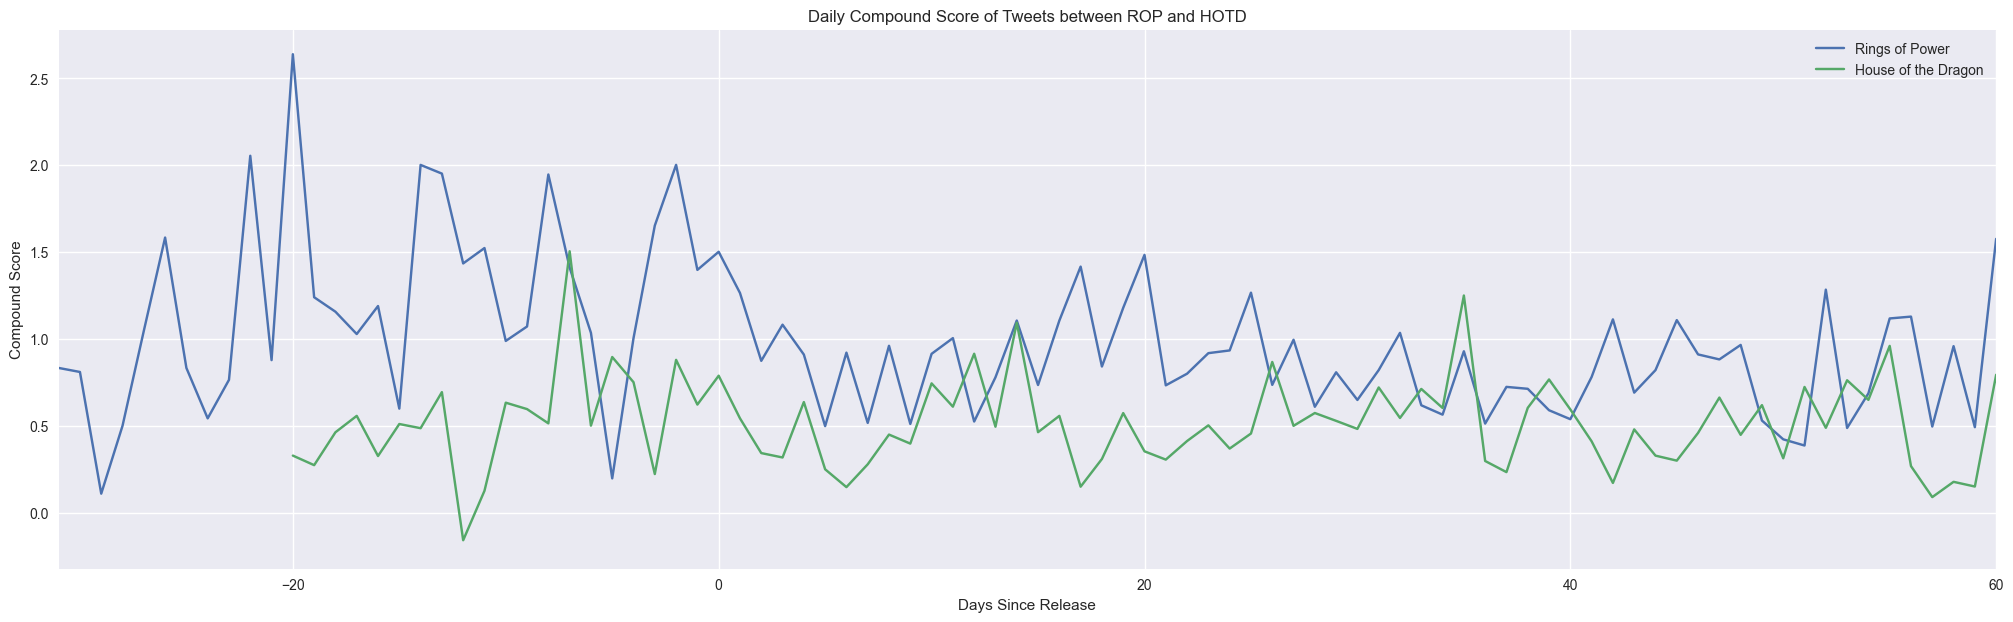

In [15]:
rop_df = rop.groupby(['days_since_release'])['adjcomp'].mean()
hotd_df = hotd.groupby(['days_since_release'])['adjcomp'].mean()

fig, ax = plt.subplots(figsize=(25, 7))
rop_df.plot(x="days_since_release")
hotd_df.plot(x="days_since_release")
plt.grid(zorder=0)
#plt.axvline("2022-09-01", color="blue", linestyle="dashed")
#plt.axvline("2022-08-21", color="green", linestyle="dashed")
plt.xlim([-31, 60])
plt.legend(['Rings of Power', 'House of the Dragon'])
plt.xlabel('Days Since Release')
plt.ylabel('Compound Score')
plt.title('Daily Compound Score of Tweets between ROP and HOTD')
plt.show()

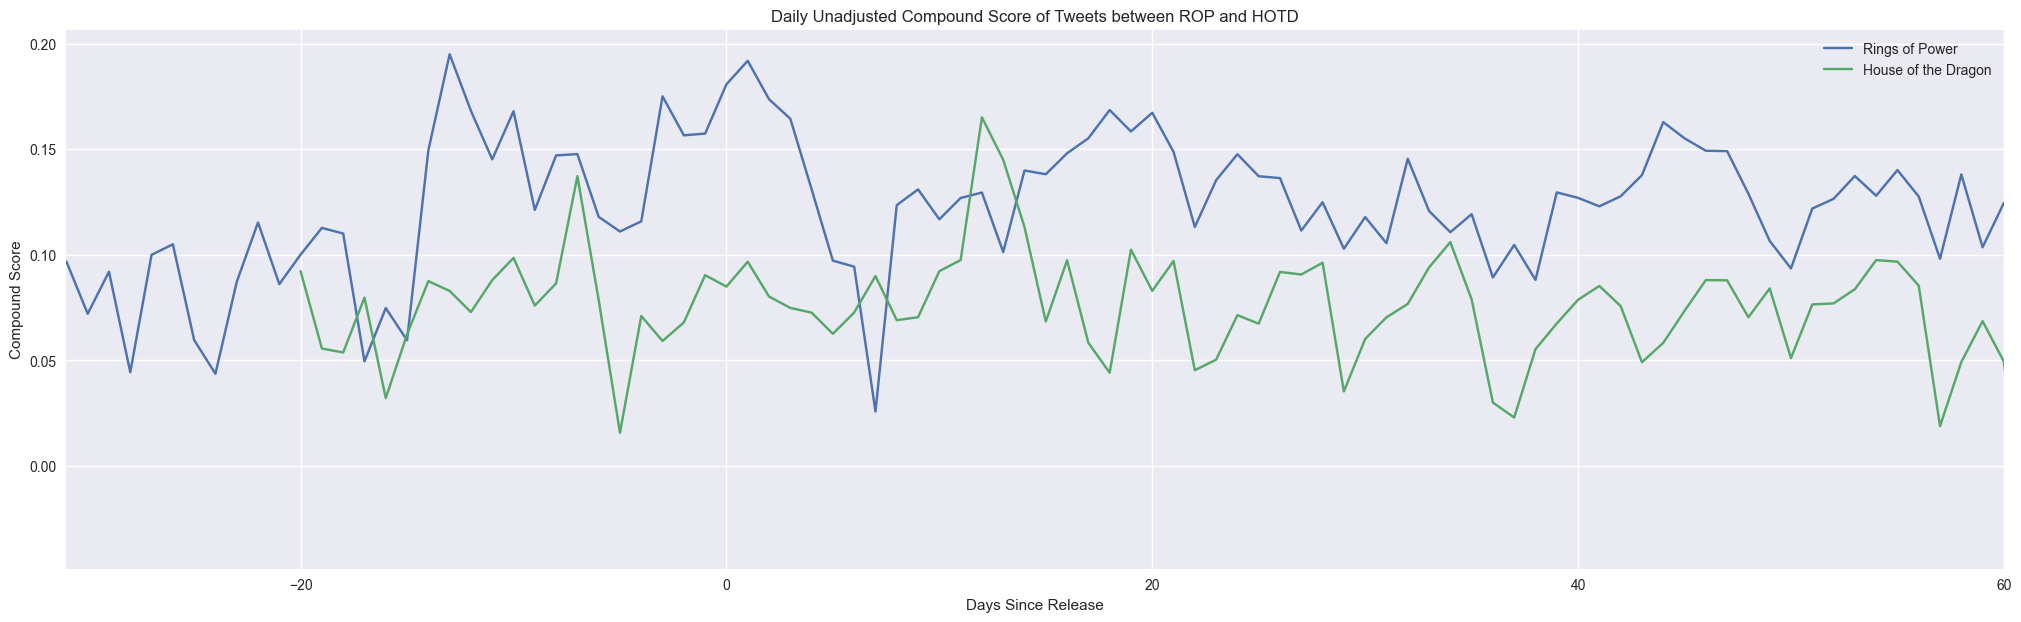

In [16]:
rop_df = rop.groupby(['days_since_release'])['comp'].mean()
hotd_df = hotd.groupby(['days_since_release'])['comp'].mean()

fig, ax = plt.subplots(figsize=(25, 7))
rop_df.plot()
hotd_df.plot()
plt.grid(zorder=0)
#plt.axvline("2022-09-01", color="blue", linestyle="dashed")
#plt.axvline("2022-08-21", color="green", linestyle="dashed")
plt.xlim([-31, 60])
plt.legend(['Rings of Power', 'House of the Dragon'])
plt.xlabel('Days Since Release')
plt.ylabel('Compound Score')
plt.title('Daily Unadjusted Compound Score of Tweets between ROP and HOTD')
plt.show()

In [17]:
dates = [str(i) for i in rop['date'].unique()]

rop_days_pos = rop[rop['adjcomp'] > 0].groupby('days_since_release')
rop_days_neg = rop[rop['adjcomp'] < 0].groupby('days_since_release')

percomp = abs(rop_days_pos['adjcomp'].sum()) /(
            abs(rop_days_pos['adjcomp'].sum()) +
            abs(rop_days_neg['adjcomp'].sum()))

hotd_days_pos = hotd[hotd['adjcomp'] > 0].groupby('days_since_release')
hotd_days_neg = hotd[hotd['adjcomp'] < 0].groupby('days_since_release')

percomp2 = abs(hotd_days_pos['adjcomp'].sum()) /(
            abs(hotd_days_pos['adjcomp'].sum()) +
            abs(hotd_days_neg['adjcomp'].sum()))



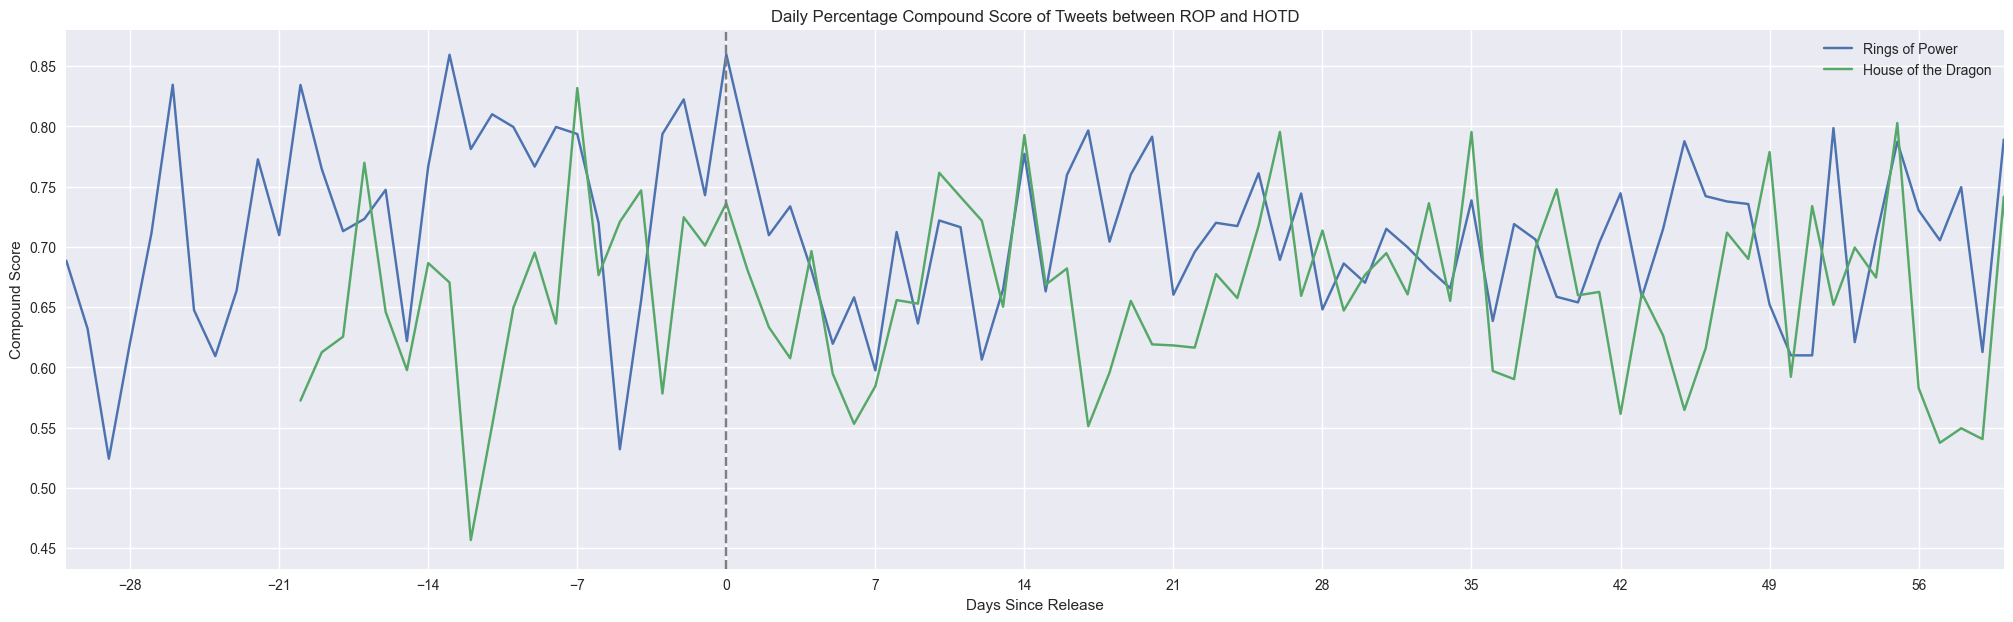

In [19]:
fig, ax = plt.subplots(figsize=(25, 7))
#fig.autofmt_xdate()
ax.set_xticks(np.arange(-49, 100, 7))
plt.plot(percomp)
plt.plot(percomp2)
plt.grid(zorder=0)
#plt.axvline("2022-09-01", color="blue", linestyle="dashed")
#plt.axvline("2022-08-21", color="green", linestyle="dashed")
plt.axvline(0, color='tab:grey', linestyle='dashed')
plt.xlim([-31, 60])
plt.legend(['Rings of Power', 'House of the Dragon'])
plt.xlabel('Days Since Release')
plt.ylabel('Compound Score')
plt.title('Daily Percentage Compound Score of Tweets between ROP and HOTD')
plt.show()

In [20]:
rop['days_since_release'].value_counts().sort_index()

-31     471
-30     528
-29     551
-28     650
-27     408
       ... 
 56    1061
 57    1103
 58     946
 59     990
 60     832
Name: days_since_release, Length: 92, dtype: int64

### Word Cloud

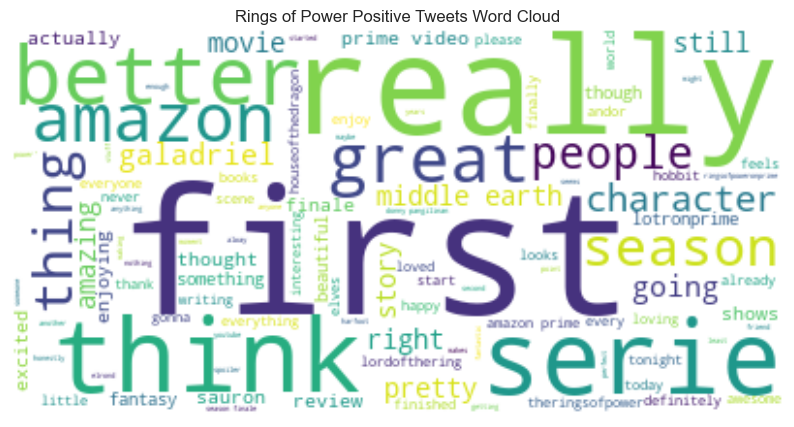

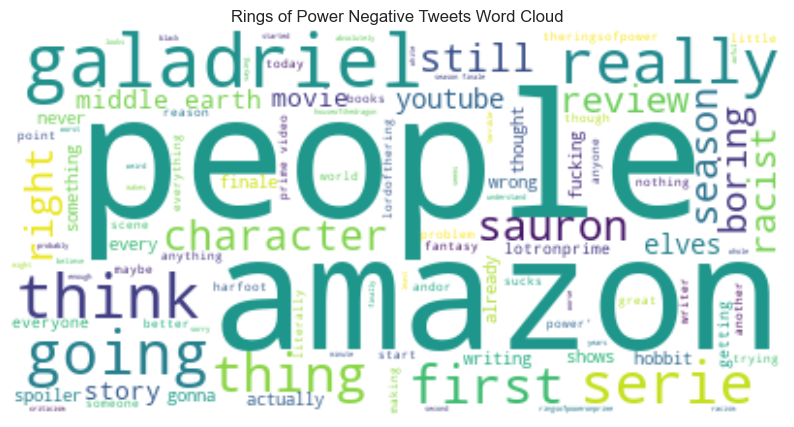

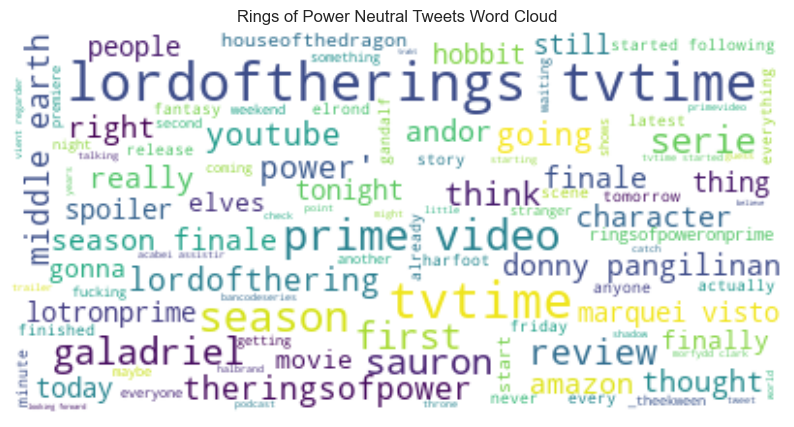

In [21]:
from wordcloud import  WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)

# join all reviews
text_pos = " ".join(i for i in rop[rop['sentiment']=='pos'].text)
text_neg = " ".join(i for i in rop[rop['sentiment']=='neg'].text)
text_neu = " ".join(i for i in rop[rop['sentiment']=='neu'].text)

# Add some extra words ad hoc for our purpose
stop_words = ['rings', 'of', 'power', 'ringsofpower', 'withdonny', 'donnypangilinan', 'house', 'dragon', 'dragons', 'episode', 'episodes',
            'watching', 'watched', 'watch', 'tolkien']
stopwords.update(stop_words)

# Generate the image
wordcloud_pos = WordCloud(stopwords=stopwords, background_color="white", max_words=100, min_word_length=5).generate(text_pos)
wordcloud_neg = WordCloud(stopwords=stopwords, background_color="white", max_words=100, min_word_length=5).generate(text_neg)
wordcloud_neu = WordCloud(stopwords=stopwords, background_color="white", max_words=100, min_word_length=5).generate(text_neu)

# visualize the image
fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Rings of Power Positive Tweets Word Cloud')
plt.show()

fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title('Rings of Power Negative Tweets Word Cloud')
plt.show()

fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis("off")
plt.title('Rings of Power Neutral Tweets Word Cloud')
plt.show()

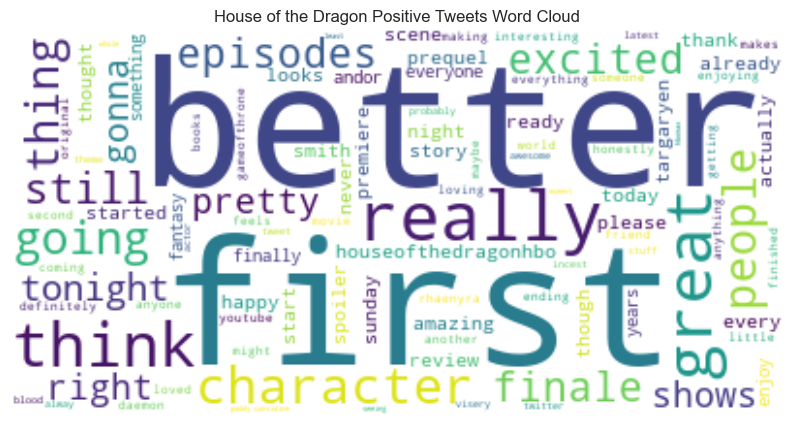

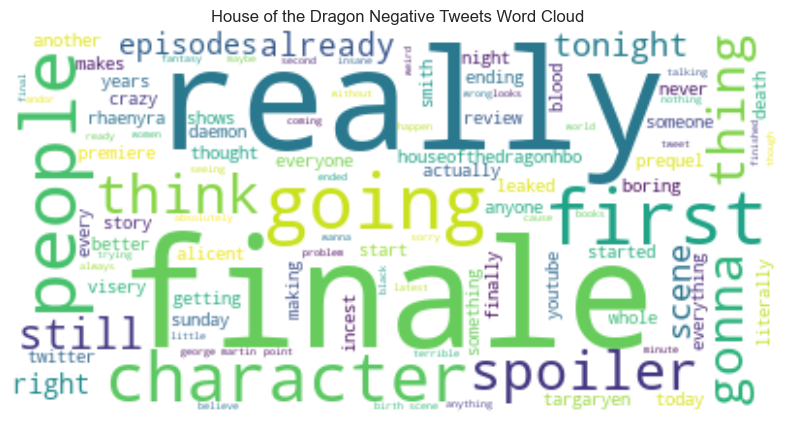

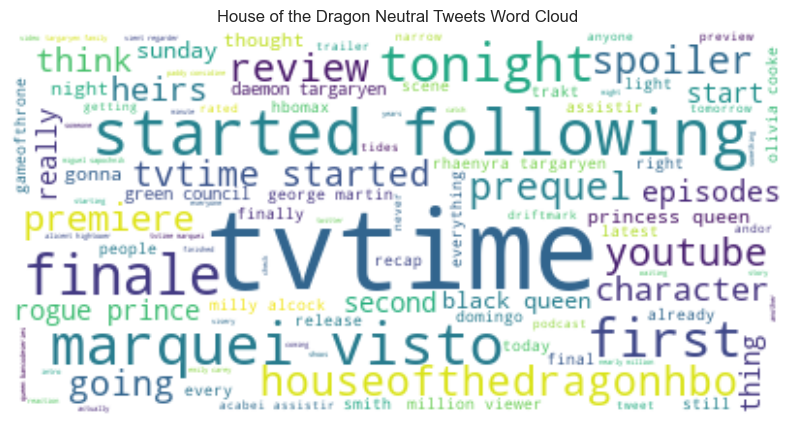

In [22]:
stopwords = set(STOPWORDS)

# join all reviews
text_pos = " ".join(i for i in hotd[hotd['sentiment']=='pos'].text)
text_neg = " ".join(i for i in hotd[hotd['sentiment']=='neg'].text)
text_neu = " ".join(i for i in hotd[hotd['sentiment']=='neu'].text)

# Add some extra words ad hoc for our purpose
stop_words = ['house', 'of', 'the', 'dragon', 'dragons', 'dragon\'', 'hotd', 'houseofthedragon', 
            'rings', 'power', 'episode', 'watch', 'fucking', 'watching', 'watched', 'throne', 'thrones',
            'seasons', 'series', 'season']
stopwords.update(stop_words)

# Generate the image
wordcloud_pos = WordCloud(stopwords=stopwords, background_color="white", max_words=100, min_word_length=5).generate(text_pos)
wordcloud_neg = WordCloud(stopwords=stopwords, background_color="white", max_words=100, min_word_length=5).generate(text_neg)
wordcloud_neu = WordCloud(stopwords=stopwords, background_color="white", max_words=100, min_word_length=5).generate(text_neu)

# visualize the image
fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title('House of the Dragon Positive Tweets Word Cloud')
plt.show()

fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title('House of the Dragon Negative Tweets Word Cloud')
plt.show()

fig=plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis("off")
plt.title('House of the Dragon Neutral Tweets Word Cloud')
plt.show()